In [1]:
%pip install segmentation-models-pytorch
%pip install -U git+https://github.com/albumentations-team/albumentations

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: segmentation-models-pytorch in c:\users\sriji\appdata\local\programs\python\python311\lib\site-packages (0.3.3)




[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/albumentations-team/albumentations to c:\users\sriji\appdata\local\temp\pip-req-build-w6qw4esc
  Resolved https://github.com/albumentations-team/albumentations to commit c70e664e060bfd7463c20674927aed217f72d437
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations 'C:\Users\sriji\AppData\Local\Temp\pip-req-build-w6qw4esc'

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git
%pip install --upgrade opencv-contrib-python

Cloning into 'Human-Segmentation-Dataset-master'...
Updating files:  92% (539/585)
Updating files:  93% (545/585)
Updating files:  94% (550/585)
Updating files:  95% (556/585)
Updating files:  96% (562/585)
Updating files:  97% (568/585)
Updating files:  98% (574/585)
Updating files:  99% (580/585)
Updating files: 100% (585/585)
Updating files: 100% (585/585), done.


Note: you may need to restart the kernel to use updated packages.Collecting opencv-contrib-python
  Obtaining dependency information for opencv-contrib-python from https://files.pythonhosted.org/packages/81/3c/bbb3ceee9fbefc505f98c24dafda68c7b3c4f83b6951c0712b4623fe4cce/opencv_contrib_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.8 MB 660.6 kB/s eta 0:01:08
   ---------------------------------------- 0.1/44.8 MB 871.5 kB/s eta 0:00:52
   ---------------------------------------- 0.2/44.8 MB 1.5 MB/s eta 0:00:31
   ---------------------------------------- 0.3/44.8 MB 1.6 MB/s eta 0:00:29
   ---------------------------------------- 0.4/44.8 MB 1.7 MB/s eta 0:00:27
   ---------------------------------------- 0.5/44.8 MB 1.8 MB/s eta 0:00:25
    --------------------------------------- 0.6/44.8 MB 1.9


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import sys
sys.path.append('./Human-Segmentation-Dataset-master')

In [40]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [94]:
CSV_FILE='./Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='./'

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS=25
LR=0.003
IMAGE_SIZE = 320

ENCODER ='timm-efficientnet-b0'
ENCODER_WEIGHTS='imagenet'


In [42]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [43]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0



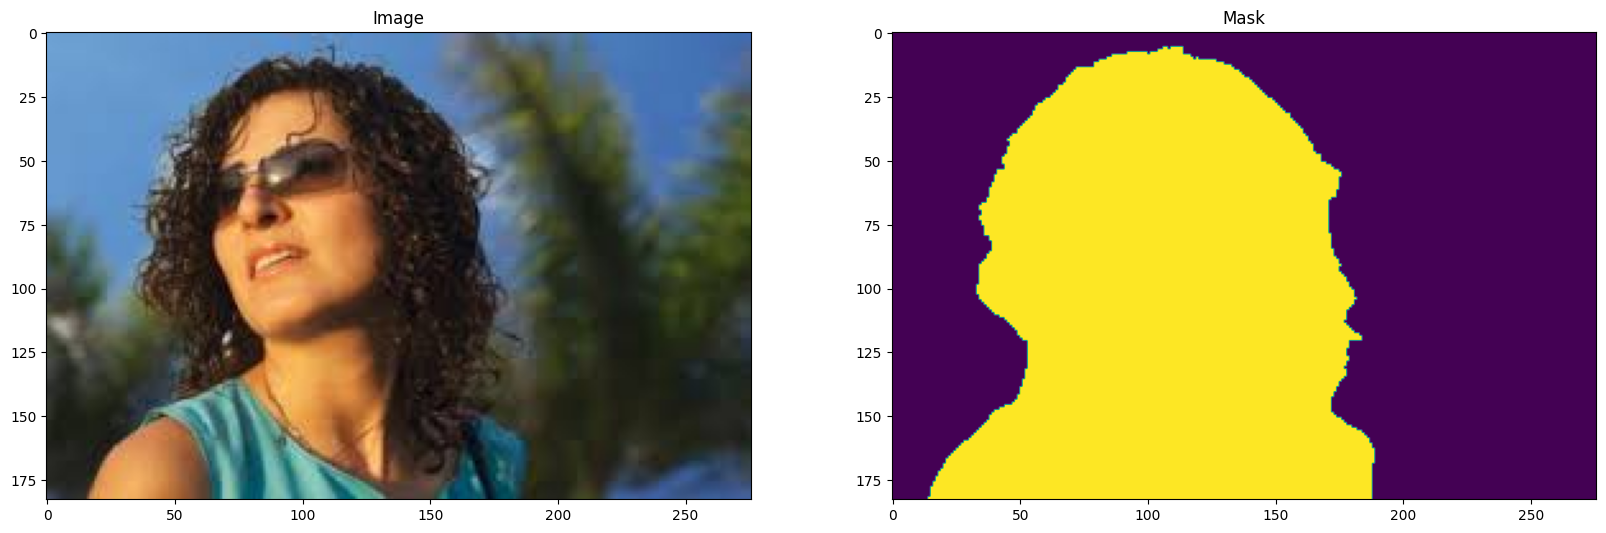

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.set_title("Image")
ax1.imshow(image)

ax2.set_title("Mask")
ax2.imshow(mask)

In [45]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

**Augmentation Functions**

In [46]:
import albumentations as A


In [57]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ])


def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        
        
    ])


In [58]:
from torch.utils.data import Dataset


In [82]:
class SegmentationDataset(Dataset):


    def __init__(self,df,augmentations):
        
        self.df = df
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):

        row = self.df.iloc[idx]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask= cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image=np.transpose(image,(2,0,1)).astype(np.float32)
        mask=np.transpose(mask,(2,0,1)).astype(np.float32)

        image = torch.Tensor(image) /255.0
        mask = torch.round(torch.Tensor(mask) /255.0)

        return image, mask


        

In [83]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())


In [84]:
print(len(trainset), len(validset))

232 58


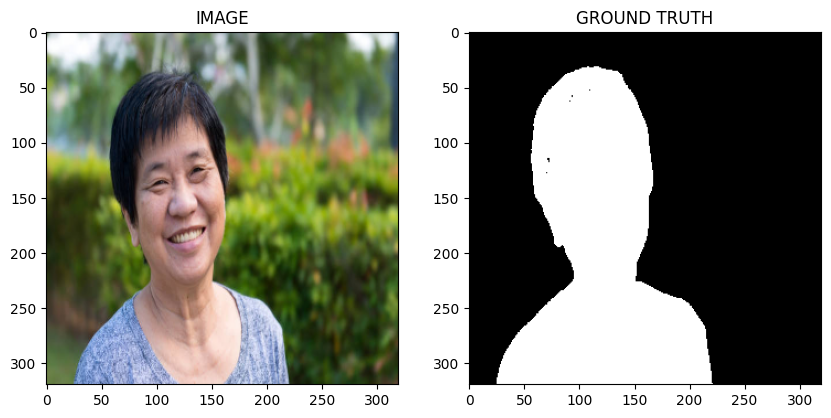

In [85]:
idx =3
image, mask = trainset[idx]

helper.show_image(image,mask)

In [86]:
from torch.utils.data import DataLoader


In [87]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
validloader = DataLoader(validset, batch_size=16)


In [88]:
print(len(trainloader), len(validloader))

15 4


In [89]:
for image, mask in trainloader:
    print(image.shape, mask.shape)
    break

torch.Size([16, 3, 320, 320]) torch.Size([16, 1, 320, 320])


In [90]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [92]:
class SegmentationModel(nn.Module):

    def __init__(self) :
        super(SegmentationModel,self).__init__()


        self.arch = smp.Unet(
            encoder_name= ENCODER,
            encoder_weights= ENCODER_WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    
    def forward(self,images, masks=None):

        logits= self.arch(images)

        if masks is not None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        
        return logits

In [95]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to C:\Users\sriji/.cache\torch\hub\checkpoints\tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:10<00:00, 1.99MB/s]


SegmentationModel(
  (arch): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
          

In [97]:
def train_fn(data_loader,model,optimizer):

    model.train()
    total_loss=0

    for images,masks in tqdm(data_loader):

        images=images.to(DEVICE)
        masks=masks.to(DEVICE)

        optimizer.zero_grad()

        logits,loss = model(images,masks)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss/len(data_loader)



In [98]:
def eval_fn(data_loader,model):

    model.eval()
    total_loss=0

    with torch.no_grad():

        for images,masks in tqdm(data_loader):

            images=images.to(DEVICE)
            masks=masks.to(DEVICE)

            logits,loss = model(images,masks)

            total_loss += loss.item()
    
    return total_loss/len(data_loader)

In [99]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [100]:
best_valid_loss = np.inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print('Saved best model')

    print(f'Epoch: {i+1}/{EPOCHS} | Train Loss: {train_loss} | Valid Loss: {valid_loss}')

100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


Saved best model
Epoch: 1/25 | Train Loss: 0.7452824513117472 | Valid Loss: 0.8781933486461639


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


Saved best model
Epoch: 2/25 | Train Loss: 0.3503619611263275 | Valid Loss: 0.7423175424337387


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


Saved best model
Epoch: 3/25 | Train Loss: 0.3304161598285039 | Valid Loss: 0.29524683207273483


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


Saved best model
Epoch: 4/25 | Train Loss: 0.25517884492874143 | Valid Loss: 0.2510477118194103


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


Saved best model
Epoch: 5/25 | Train Loss: 0.23813570241133372 | Valid Loss: 0.23461876437067986


100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


Saved best model
Epoch: 6/25 | Train Loss: 0.18603479663530986 | Valid Loss: 0.19991518557071686


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


Saved best model
Epoch: 7/25 | Train Loss: 0.16688062846660615 | Valid Loss: 0.17903226241469383


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


Epoch: 8/25 | Train Loss: 0.1639906863371531 | Valid Loss: 0.22987435013055801


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


Saved best model
Epoch: 9/25 | Train Loss: 0.18590226819117864 | Valid Loss: 0.17042016610503197


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


Epoch: 10/25 | Train Loss: 0.1435028259952863 | Valid Loss: 0.18992657586932182


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


Epoch: 11/25 | Train Loss: 0.14232526769240697 | Valid Loss: 0.21320335566997528


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


Epoch: 12/25 | Train Loss: 0.12105349500974019 | Valid Loss: 0.17921297624707222


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


Epoch: 13/25 | Train Loss: 0.13005943298339845 | Valid Loss: 0.19091100618243217


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


Epoch: 14/25 | Train Loss: 0.134162338078022 | Valid Loss: 0.21751462668180466


100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


Epoch: 15/25 | Train Loss: 0.1312244400382042 | Valid Loss: 0.18197457864880562


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


Epoch: 16/25 | Train Loss: 0.12646093169848124 | Valid Loss: 0.23874880373477936


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


Epoch: 17/25 | Train Loss: 0.14065736681222915 | Valid Loss: 0.1840796358883381


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


Epoch: 18/25 | Train Loss: 0.18312272181113562 | Valid Loss: 0.21219398826360703


100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


Epoch: 19/25 | Train Loss: 0.22728064606587092 | Valid Loss: 0.22189665213227272


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


Epoch: 20/25 | Train Loss: 0.16500135759512582 | Valid Loss: 0.25382527709007263


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


Epoch: 21/25 | Train Loss: 0.1433465282122294 | Valid Loss: 0.2661779969930649


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


Saved best model
Epoch: 22/25 | Train Loss: 0.14623185694217683 | Valid Loss: 0.1694791540503502


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


Epoch: 23/25 | Train Loss: 0.11583419541517893 | Valid Loss: 0.17793180420994759


100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


Epoch: 24/25 | Train Loss: 0.11391833821932475 | Valid Loss: 0.17702222429215908


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


Saved best model
Epoch: 25/25 | Train Loss: 0.11006880005200705 | Valid Loss: 0.15937188640236855


In [103]:
idx = 2
model.load_state_dict(torch.load('./best_model.pt'))

image,mask = validset[idx]

logits_mask= model(image.to(DEVICE).unsqueeze(0))
pred_mask= torch.sigmoid(logits_mask)
pred_mask= (pred_mask>0.5)*1.0



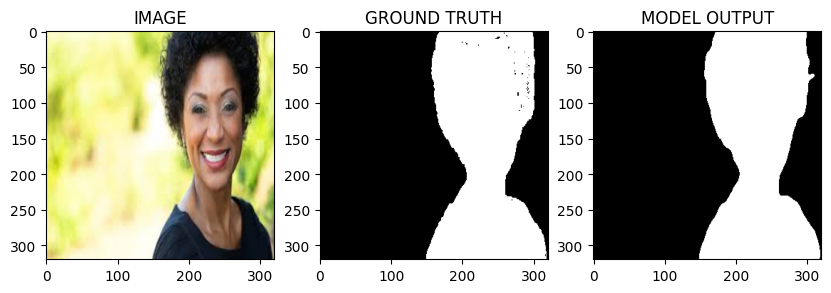

In [104]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))